In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import librosa
import torch
import torchaudio.functional as F
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Audio, display

from augmentations.augmentations import *
import augmentations.augmentations.misc as misc

from data.data_generator import (
    AudioSetViewsDataset,
    MultipleBalancedTrainSampler,
    collate_fn,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def audio_to_melspectrogram(audio, sampling_rate, hop_length=256, n_fft=2048):
    spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sampling_rate, hop_length=hop_length, n_fft=n_fft
    )
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram


def show_melspectrogram(
    spectrogram, sampling_rate, title="log-frequency power spectrogram"
):
    librosa.display.specshow(spectrogram, x_axis="time", y_axis="mel", sr=sampling_rate)
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.show()


def show_signal(audio):
    plt.plot(audio)
    plt.title("Signal")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()


def show_and_play_signal(audio, sample_rate):
    plt.plot(audio)
    plt.title("Signal")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()
    display(Audio(audio, rate=sample_rate))


def read_as_melspectrogram(file_path):
    audio, sampling_rate = misc.load_audio(file_path)
    spectrogram = audio_to_melspectrogram(audio, sampling_rate)
    return spectrogram

In [17]:
data_root = "/home/klig/datasets/audioset/"
data_type = "full_train"

indexes_hdf5_path = os.path.join(
    data_root, "hdf5s", "indexes", "{}.h5".format(data_type)
)

In [27]:
batch_size = 32
sample_rate = 8000
augmentation = "mixup"
black_list_csv = "metadata/dcase2017task4.csv"
num_workers = 4
sample_rate = 8000
num_views = 2

transforms = Compose(
    [
        RandomCropExpand(8 * sample_rate, 10 * sample_rate, pad_type="repeat"),
        RandomApply(PolarityInversion(), 0.5),
        Noise(min_snr=0.1, max_snr=0.3),
        RandomGain(),
        RandomApply(HighLowPass(sample_rate), p=0.5),
        RandomApply(PitchShift(10 * sample_rate, sample_rate), p=0.5),
        RandomBackgroundNoise(
            noise_root="/home/klig/datasets/arabic-natural-audio",
            sample_rate=sample_rate,
            segment_size=sample_rate * 10,
            bank_size=2,
            snr_dbs_range=[5, 10],
        ),
        RandomApply(RandomRIR(), p=0.5),
        RandomApply(RandomEncoder(sample_rate=sample_rate), p=0.5),
    ]
)


dataset = AudioSetViewsDataset(transforms=transforms, num_views=num_views)
sampler = MultipleBalancedTrainSampler(
    indexes_hdf5_path=indexes_hdf5_path,
    batch_size=batch_size,
    num_repeat=2,
)

loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_sampler=sampler,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=True,
)

In [28]:
batch_data_dict = next(iter(loader))
waveforms = batch_data_dict["waveform"]
waveforms = np.split(waveforms, waveforms.shape[1], axis=1)
waveforms = np.concatenate(waveforms, axis=0).squeeze()

[W encode_process.cpp:170] Warning: "vorbis" encoder is selected. Enabling '-strict experimental'. If this is not desired, please provide "strict" encoder option with desired value. (function operator())
[W encode_process.cpp:170] Warning: "vorbis" encoder is selected. Enabling '-strict experimental'. If this is not desired, please provide "strict" encoder option with desired value. (function operator())
[W encode_process.cpp:170] Warning: "vorbis" encoder is selected. Enabling '-strict experimental'. If this is not desired, please provide "strict" encoder option with desired value. (function operator())
[W encode_process.cpp:170] Warning: "vorbis" encoder is selected. Enabling '-strict experimental'. If this is not desired, please provide "strict" encoder option with desired value. (function operator())


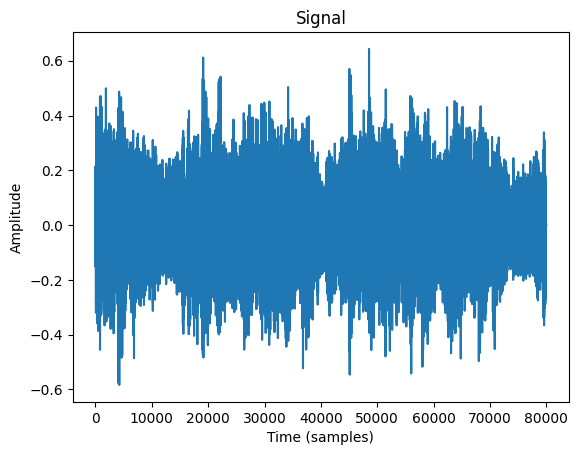

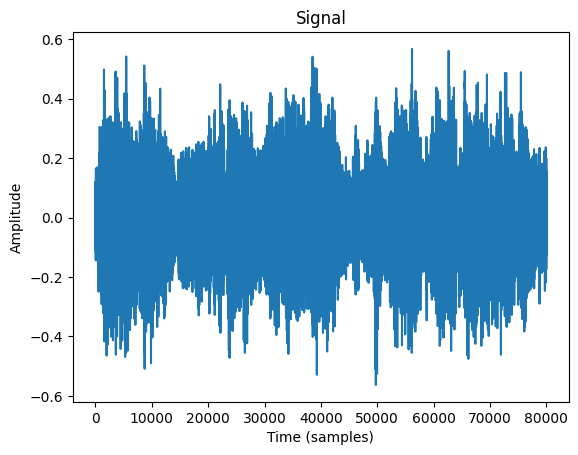

In [29]:
index = 2
audio = waveforms[index]
show_and_play_signal(audio, sample_rate)
audio = waveforms[index + batch_size]
show_and_play_signal(audio, sample_rate)